In [1]:
import jax
import jax.numpy as jnp
import qutip as qt
import numpy as np
from functools import reduce
from jax import jit
from jax.scipy.linalg import expm

import matplotlib.pyplot as plt
from functools import partial

In [2]:
@jit
def apply_iteration(rho_system, rho_bath, U):
    rho_total = jnp.kron(rho_system, rho_bath)

    rho_evolved = U @ rho_total @ jnp.conjugate(U.T)

    rho_S_evolved = jnp.einsum("ijkj", rho_evolved.reshape([2, 2, 2, 2]))
    return rho_S_evolved


# f_partial_for_scan = lambda rho_s, _: apply_iteration(rho_s, rho_bath, U)

In [39]:
d1 = 2
d2 = 2

phi = 0.1 * np.pi / 2
theta = 0.1 * np.pi / 2

omega_1 = np.pi
omega_2 = np.pi

H_1 = 1*omega_1 / 2 * qt.sigmaz()
H_2 = 1.7*omega_2 / 2 * qt.sigmaz()

H_S = qt.tensor(H_1, qt.identity(d1)) + qt.tensor(qt.identity(d2), H_2)

H_I = phi * (
    qt.tensor(qt.sigmax(), qt.sigmax()) + qt.tensor(qt.sigmay(), qt.sigmay())
) + theta * (qt.tensor(qt.sigmaz(), qt.sigmaz()))

# reduce(
#     lambda a, b: a + b,
#     (map(lambda i: qt.tensor(i, i), [qt.sigmax(), qt.sigmay()])),
# )

H_T = H_S + H_I

T = 1


eigvals_2 = list(np.linalg.eigh(H_2)[0])


rho_un = np.diag(
    list(map(lambda eigval: np.exp(-(1 / (1 * T)) * eigval), eigvals_2))
)
rho_bath = rho_un / np.trace(rho_un)
rho_bath

delta_t = 0.2

rho_system_0 = jnp.array(
    qt.ket2dm((1 * qt.basis(2, 0) + 1 * qt.basis(2, 1)).unit()).full()
)

U = expm(1j * (delta_t * H_T.full()))
# rho_bath

In [41]:
rho_bath

array([[0.99523038, 0.        ],
       [0.        , 0.00476962]])

In [40]:
rho_system_0

Array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]], dtype=complex64)

In [42]:
re = []
rho_s_i = rho_system_0
for _ in range(2000):
    rho_s_i = apply_iteration(rho_s_i, rho_bath, U)
    re.append(rho_s_i)

re = np.array(re)

/home/antonio/miniconda3/envs/jax_qdots/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/antonio/miniconda3/envs/jax_qdots/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


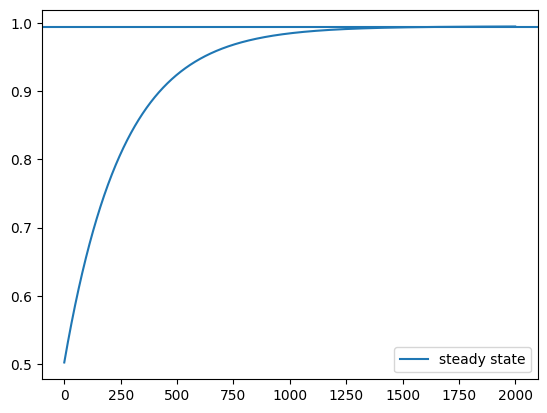

In [43]:
plt.plot(re[:, 0, 0])
plt.axhline(jnp.real(rho_bath[0, 0]), label="steady state")
plt.legend()
plt.show()

In [429]:
from scipy.constants import k, hbar